In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import math
import operator

from datetime import datetime

# Loading the data

For this problem '*Uber Pickups*' dataset was chosen. It represents the data for different New York Uber pickups.
Our goal is, by analysing this dataset, to predict the amount of pickups for each line presented.

In [3]:
X_data = pd.read_csv('data/trainX.csv')
Y_data = pd.read_csv('data/trainY.csv')

In [4]:
X_data.head()

,id,pickup_dt,borough,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,26112,2015-06-12 16:00:00,NaN,6.0,9.1,82.0,60.0,1014.2,0.0,0.00,0.240000,0.000000,N
1,26896,2015-06-17 12:00:00,EWR,7.0,10.0,72.0,58.0,1018.9,0.0,0.00,0.270000,0.000000,N
2,2263,2015-01-15 08:00:00,Queens,3.0,10.0,27.0,17.0,1021.6,0.0,0.00,0.000000,0.000000,N
3,10453,2015-03-07 15:00:00,Brooklyn,7.0,9.1,24.0,7.0,1024.3,0.0,0.29,0.551667,18.583333,N
4,19043,2015-04-30 08:00:00,EWR,9.0,10.0,49.0,40.0,1006.7,0.0,0.00,0.050000,0.000000,N


Decision Tree Regressor algorithm will be implemented here to predict the amount of pickups.

# Preparing the data

In [5]:
def transform_date(dataset):
    def str_to_secs(s):
        time = datetime.strptime(s,"%Y-%m-%d %H:%M:%S").time()
        return time.second+time.minute*60+time.hour*3600
    def str_to_hour(s):
        return datetime.strptime(s,"%Y-%m-%d %H:%M:%S").time().hour
    data = dataset.copy()
    data.pickup_dt = data.pickup_dt.apply(str_to_hour)
    return data

In [6]:
def apply_one_hot_encoding(dataset, attr):
    # didn't use it
    data = pd.DataFrame(dataset, copy=true)
    uniques = set(data[attr].values)
    uniques.remove('nan')
    for value in uniques:
        new_value = f'{attr}_{value}'
        data[new_value] = (data[attr] == value)
    del data[attr]
    return data

In [7]:
def bin_data(dataset, column):
# data binning for categorizing continous values:

    bins_map = {}

    idxs, bins = pd.cut(dataset[column], bins=20, labels=False, retbins=True)

    for bin_num, border_val in enumerate(bins):
        if bin_num == len(bins) - 1:
            continue
        else:
            high = bins[bin_num + 1]
        bins_map[bin_num] = {
            'low': border_val,
            'high': high,
            #'amount': amounts[bin_num]
        }
    return idxs, bins_map

In [8]:
def prepare_data(dataset):
    dataset_copy = dataset.fillna(value={'borough': 'Unknown'})
    dataset_copy = dataset_copy.drop('id', axis='columns')
    dataset_copy = transform_date(dataset_copy)
    return dataset_copy

In [9]:
X_prepared = prepare_data(X_data)

In [10]:
merged = pd.merge(X_data, Y_data, on='id')
Y = merged['pickups']

Splitting dataset into 10 equal pieces:

(didn't use it - just a small note that can be used for K-fold validation later)

In [244]:
X_copy = pd.DataFrame(X_prepared, copy=True)
subsets = []
amount = int(len(X_copy) / 10)

for x in range(0, 10):
    subsets.append(X_copy.sample(n=amount))
    X_copy.drop(subsets[x].index, inplace=True)

# Implementing Decision Tree Regressor (ID3 type)

In [43]:
class DecisionTree:
    """class containing methods for tree fitting and prediction making"""
    
    def __init__(self, max_depth=11):
        self.max_depth = max_depth
        self._binned_attrs = {}
        self.tree_model = None
        self.data = None
        self.Y = None
    
    def fit(self, X, Y):
        self.Y = Y
        self.data = X.copy()
        data = self.data
        for attr in self.data:
            if len(self.data[attr].unique()) > 30:
                self.data[attr], self._binned_attrs[attr] = bin_data(data, attr)
        self.tree_model = self._fit_tree(data)
    
    def predict(self, X):
        def find_bins(value, binned_map):
            if value < binned_map[0]['high']:
                return 0
            for bin_num, bin_def in binned_map.items():
                low = bin_def['low']
                high = bin_def['high']
                if low < value <= high:
                    return bin_num
            return max(binned_map.keys())

        data = X.copy()
        for attr, bins in self._binned_attrs.items():
            data[attr] = data[attr].apply(lambda x: find_bins(x, bins))
        
        answers = []
        for line_idx, line in data.to_dict('index').items():
            targets = []
            models = [self.tree_model]
            while models:
                model = models.pop()
                if model['type'] == 'leaf':
                    targets.extend(model['targets'])
                    continue
                attr = model['attr_name']
                attr_value = line[attr]
                if attr_value in model['choices']:
                    models.append(model['choices'][attr_value])
                else:
                    # print(f'Skipping {attr_value} of {attr} for line {line_idx}')
                    models.extend(model['choices'].values())
            vals = self.Y[targets].values
            vals_avg = sum(vals) / len(vals)
            vals_stddev = self._standard_deviation(vals)
            answers.append(int(vals_avg))
        return np.array(answers)
    
    def _standard_deviation(self, arr):
        avg = sum(arr) / len(arr)
        stddev = np.sqrt(sum((x - avg)**2 for x in arr) / len(arr))
        return stddev

    def _variation_coef(self, Y):
        stddev = self._standard_deviation(Y)
        avg = sum(Y) / len(Y)
        return stddev / avg

    def _split(self, data, colname, value):
    # returns dataframe without given colname which contains only given value of this colname
        return data.loc[data[colname] == value, data.columns.drop(colname)]

    def _choose(self, data):
        def filtered_stddev(attr, value):
            col = data[attr]
            lines_with_value = data[col == value].index
            probability = len(lines_with_value) / len(data)
            return probability * self._standard_deviation(self.Y[lines_with_value].values)
        def biased_stddev(attr):
            return sum(filtered_stddev(attr, value) for value in data[attr].unique())
        
        best_attr, lowest_biased_stddev = min([(attr, biased_stddev(attr)) for attr in data.columns], key=operator.itemgetter(1))
    
        return best_attr

    def _majority(self, classset):
        count = {}
        for attr in classset:
            if attr not in count.keys():
                count[attr] = 0
            count[attr] += 1
        sorted_class_count = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
        return sorted_class_count[0][0]

    def _fit_tree(self, data, depth=0):
        # if only one entry - return it
        # if variation coef is too small - return data
        if depth > self.max_depth \
            or data.shape[0] == 1 \
            or abs(self._variation_coef(self.Y[data.index].values) - 0.10) < 1e-10 \
            or data.shape[1] == 0:
            return dict(type='leaf', targets=data.index)
        # if only one column left - return the majority of it's values (TODO improve function)
        if data.columns.size == 1:
            best_attr = data.columns[0]
        else:
            best_attr = self._choose(data)

        uniques = data[best_attr].unique()
        # else choose best feat, create a node, go recursively
        return dict(type='node', attr_name=best_attr, choices={
            value: self._fit_tree(self._split(data, best_attr, value), depth + 1) for value in uniques
        })

In [54]:
dt = DecisionTree(max_depth=30)

x_small = X_prepared.iloc[:5000]
y_small = Y[:5000]

dt.fit(x_small, y_small)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


In [55]:
train_predicted = dt.predict(X_prepared)

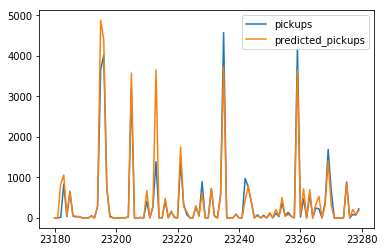

In [65]:
res = pd.DataFrame([Y_data['pickups'], pd.Series(train_predicted, name='predicted_pickups')]).T
res = res[-100:]
res.plot()

In [66]:
dt_final = DecisionTree(max_depth=30)

In [67]:
dt_final.fit(X_prepared, Y)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


In [68]:
test_X = pd.read_csv('./data/testX.csv')

In [69]:
test_prep = prepare_data(test_X)

In [70]:
test_predicted = dt_final.predict(test_prep)

In [71]:
test_predicted

array([ 232,   58,  441, ..., 3190,  330,    2])

In [72]:
dddd = pd.DataFrame([test_X['id'], pd.Series(test_predicted, name='pickups')]).T

In [73]:
dddd.to_csv('./data/testY.csv', index=False)

In [74]:
dddd.head()

,id,pickups
0,1306,232
1,3421,58
2,18809,441
3,677,2
4,23464,0
